In [280]:
# script to calculate ratios for use in TTS method 
# match rf 11 to varying BL for ratios 
# 1) RF11 UT to RF11 BL 
# 2) RF11 UT to campaign average BL 
# 3) RF11 UT to RF11, 10, 09 BL 
# author: sofia chelpon
# date created: 3-28-2020
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [418]:
import numpy as np 
import xarray as xr
import pandas as pd 
import datetime 
import seaborn as sns
import datetime as dt
from scipy.optimize import least_squares

import matplotlib
from matplotlib import pyplot as plt
import matplotlib.ticker as mticker
from mpl_toolkits import mplot3d

%matplotlib inline
%config inlinebackend.figure_format='retina'

In [419]:
# load in both toga and awas data pickles 
awas_df = pd.read_pickle("/Volumes/scdrive2/TTS_2020/get_ratios/awas_data_df.pkl")
toga_df = pd.read_pickle("/Volumes/scdrive2/TTS_2020/get_ratios/toga_data_df.pkl")

In [420]:
################# -------------------- TOGA  -------------------- #################

In [421]:
# get mean in UT and BL for 1) flights in total and 2) individual flights 
toga_means = pd.DataFrame()

# rf08
toga_means['UT - RF11'] = toga_df.loc[(toga_df['GGALT'] > 12000) & (toga_df['GGALT'] < 14000)
                                                          & (toga_df['Flight'] == 'RF11')].mean()
toga_means['BL - RF11'] = toga_df.loc[(toga_df['GGALT'] < 2000) & (toga_df['Flight'] == 'RF11')].mean()

# all rf 
toga_means['BL - All RF'] = toga_df.loc[(toga_df['GGALT'] < 2000)].mean()

#nine days prior (RF 06, 07, 08)
nineday_flts = toga_df[toga_df['Flight'].isin(['RF11', 'RF10', 'RF09', 'RF08'])]
nineday_flts = nineday_flts[nineday_flts['GGALT'] < 2000]
toga_means['BL - 9days'] = nineday_flts.mean()

toga_means = toga_means.drop('GGALT').drop('GGLAT').drop('GGLON')
#toga_means.index.name = "Trace_Gas"
toga_means = toga_means.reset_index()
toga_means = toga_means.rename(columns={'index': 'Trace_Gas'})

In [422]:
# ratios for 1) flights in total and 2) individual flights 
toga_ratios = pd.DataFrame()

toga_ratios['Trace_Gas'] = toga_means['Trace_Gas']
toga_ratios['RF11_CampAvg'] = toga_means['UT - RF11']/toga_means['BL - All RF']
toga_ratios['RF11_RF11'] = toga_means['UT - RF11']/toga_means['BL - RF11']
toga_ratios['RF11_9days'] = toga_means['UT - RF11']/toga_means['BL - 9days']
toga_ratios

# drop species names so doesnt duplicate column when merged 
toga_ratios = toga_ratios.drop('Trace_Gas', axis = 1)

In [423]:
### add attribute to each species (BL, tropo, and UT lifetimes)
# read in from xls file to make dataframe
mypath2 = '/Volumes/scdrive2/TTS_2020/contrast_readin/toga_lodhalf/toga_lifetimes_12162019.xlsx'
toga_lifetimes = pd.read_excel(mypath2)

# merge lifetimes to ratios
toga_ratios_full = toga_lifetimes.merge(toga_ratios, left_index=True, right_index=True)
toga_ratios_full.insert(0, 'Instrument', 'TOGA')

In [424]:
toga_ratios_full

,Instrument,Trace_Gas,BL_tau,TROPO_tau,UT_tau,RF11_CampAvg,RF11_RF11,RF11_9days
0,TOGA,Acetaldehyde,0.289063,0.365920,0.376967,0.330500,0.254290,0.361579
1,TOGA,n_Butane,1.959376,3.813463,8.057685,0.121756,0.444384,0.226705
2,TOGA,i_Butane,2.175570,4.031311,7.903592,0.193812,0.605284,0.344903
3,TOGA,Benzene,3.755136,6.447323,11.947207,0.510844,0.776687,0.732588
4,TOGA,C3H8,4.214557,9.062693,22.450000,0.369928,1.295028,0.621924
5,TOGA,Methanol,5.160001,9.567463,20.040000,0.523531,0.535780,0.551562
6,TOGA,Bromoform,15.069605,23.166062,33.432173,0.643168,1.046715,0.746794
7,TOGA,Tetrachloroethylene,27.471720,77.860538,317.837040,0.704960,1.085581,0.794124
8,TOGA,Dibromomethane,39.129546,95.533111,306.353687,0.941895,1.024895,0.940752
9,TOGA,Dichloromethane,45.867749,109.800998,343.676023,0.870483,0.904175,0.959111


In [425]:
################# -------------------- AWAS  -------------------- #################

In [426]:
# get mean in UT and BL for 1) flights in total and 2) individual flights 
awas_means = pd.DataFrame()

# rf08
awas_means['UT - RF11'] = awas_df.loc[(awas_df['GGALT'] > 12000) & (awas_df['GGALT'] < 14000)
                                                          & (awas_df['Flight'] == 'RF11')].mean()
awas_means['BL - RF11'] = awas_df.loc[(awas_df['GGALT'] < 2000) & (awas_df['Flight'] == 'RF11')].mean()

# all rf 
awas_means['BL - All RF'] = awas_df.loc[(awas_df['GGALT'] < 2000)].mean()

# nine days prior (RF 06, 07, 08)
del nineday_flts
nineday_flts = awas_df[awas_df['Flight'].isin(['RF11', 'RF10', 'RF09', 'RF08'])]
nineday_flts = nineday_flts[nineday_flts['GGALT'] < 2000]
awas_means['BL - 9days'] = nineday_flts.mean()

awas_means = awas_means.drop('GGALT').drop('GGLAT').drop('GGLON')
#toga_means.index.name = "Trace_Gas"
awas_means = awas_means.reset_index()
awas_means = awas_means.rename(columns={'index': 'Trace_Gas'})

In [427]:
# ratios for 1) flights in total and 2) individual flights 
awas_ratios = pd.DataFrame()

awas_ratios['Trace_Gas'] = awas_means['Trace_Gas']
awas_ratios['RF11_CampAvg'] = awas_means['UT - RF11']/awas_means['BL - All RF']
awas_ratios['RF11_RF11'] = awas_means['UT - RF11']/awas_means['BL - RF11']
awas_ratios['RF11_9days'] = awas_means['UT - RF11']/awas_means['BL - 9days']

# drop species names so doesnt duplicate column when merged 
awas_ratios = awas_ratios.drop('Trace_Gas', axis = 1)

In [428]:
### add attribute to each species (BL, tropo, and UT lifetimes)
# read in from xls file to make dataframe
mypath2 = '/Volumes/scdrive2/TTS_2020/contrast_readin/awas/awas_lifetimes_12162019.xlsx'
awas_lifetimes = pd.read_excel(mypath2)
len(awas_lifetimes)

# merge lifetimes to ratios 
awas_ratios_full = awas_lifetimes.merge(awas_ratios, left_index=True, right_index=True)
awas_ratios_full.insert(0, 'Instrument', 'AWAS')

In [429]:
awas_ratios_full

,Instrument,Trace_Gas,BL_tau,TROPO_tau,UT_tau,RF11_CampAvg,RF11_RF11,RF11_9days
0,AWAS,C2H6_Ethane,18.555721,48.949092,167.260709,0.612471,0.867341,0.745708
1,AWAS,C2H2_Ethyne,5.422335,9.603369,18.712675,0.587254,0.864908,0.874613
2,AWAS,C3H8_Propane,4.214557,9.062693,22.450000,0.235547,0.886752,0.437764
3,AWAS,C4H10_Isobutane,2.175570,4.031311,7.903592,0.133441,0.933333,0.308013
4,AWAS,C4H10_nButane,1.959376,3.813463,8.057685,0.139745,1.128682,0.349258
5,AWAS,C5H12_nPentane,1.214449,2.312606,4.723079,0.072798,1.291667,0.235562
6,AWAS,C6H6_Benzene,3.755136,6.447323,11.947207,0.550537,0.821719,0.837547
7,AWAS,OCS_Carbonyl_sulfide,2000.000000,2000.000000,2000.000000,1.003749,0.999544,1.018553
8,AWAS,C2H6S_Dimethyl_sulfide,0.955122,1.689426,3.279163,0.005929,0.012411,0.005964
9,AWAS,CCl2F2_CFC_12,37000.000000,37000.000000,37000.000000,1.005888,0.998242,1.004465


In [430]:
################# -------------------- MERGE THE TWO  -------------------- #################

In [443]:
master_list = awas_ratios_full
master_list = master_list.append(toga_ratios_full, ignore_index = True, sort = False)

# pickle this!! 
master_list.to_pickle("./contrast_ratios_rf11.pkl")

# look at output 
master_list[master_list['Trace_Gas'] == 'Dichloromethane'].drop('BL_tau', axis = 1).drop('UT_tau', axis = 1)

,Instrument,Trace_Gas,TROPO_tau,RF11_CampAvg,RF11_RF11,RF11_9days
49,TOGA,Dichloromethane,109.800998,0.870483,0.904175,0.959111


In [432]:
##########################################################################################

In [433]:
########## find which tracers are > 0.9 

In [248]:
gt = master_list[master_list['BL_tau'] < 100]
gt_campavg = gt[gt['RF11_CampAvg'] > 0.9]
gt_campavg.drop('TROPO_tau', axis = 1).drop('UT_tau', axis = 1)

,Instrument,Trace_Gas,BL_tau,RF11_CampAvg,RF11_RF11,RF11_9days
48,TOGA,Dibromomethane,39.129546,0.941895,1.024895,0.940752


In [249]:
gt_rf11 = gt[gt['RF11_RF11'] > 0.9]
gt_rf11.drop('TROPO_tau', axis = 1).drop('UT_tau', axis = 1)

,Instrument,Trace_Gas,BL_tau,RF11_CampAvg,RF11_RF11,RF11_9days
3,AWAS,C4H10_Isobutane,2.175570,0.133441,0.933333,0.308013
4,AWAS,C4H10_nButane,1.959376,0.139745,1.128682,0.349258
5,AWAS,C5H12_nPentane,1.214449,0.072798,1.291667,0.235562
22,AWAS,CH2Cl2_Methylene_chloride,45.867749,0.801288,0.922755,0.891153
23,AWAS,CHCl3_Chloroform,52.944984,0.760835,0.914093,0.837184
31,AWAS,CH2BrCl_Bromochloromethane,45.186536,0.822857,1.014493,0.853569
32,AWAS,CH2Br2_Methylene_bromide,39.129546,0.800343,0.958470,0.845870
33,AWAS,CHBrCl2_Bromodichloromethane,27.464993,0.750049,1.020833,0.832588
44,TOGA,C3H8,4.214557,0.369928,1.295028,0.621924
46,TOGA,Bromoform,15.069605,0.643168,1.046715,0.746794


In [250]:
gt_9days = gt[gt['RF11_9days'] > 0.9]
gt_9days.drop('TROPO_tau', axis = 1).drop('UT_tau', axis = 1)

,Instrument,Trace_Gas,BL_tau,RF11_CampAvg,RF11_RF11,RF11_9days
48,TOGA,Dibromomethane,39.129546,0.941895,1.024895,0.940752
49,TOGA,Dichloromethane,45.867749,0.870483,0.904175,0.959111


In [260]:
########## plot distributions - UT 

In [283]:
# isolate data in UT for RF11 alone, and camp avg. 
# RF11 only 
gt_ut_rf11 = toga_df.loc[(toga_df['GGALT'] > 12000) & (toga_df['GGALT'] < 14000)
                                                          & (toga_df['Flight'] == 'RF11')]
gt_ut_rf11 = gt_ut_rf11[['Benzene', 'C3H8', 'Dibromomethane', 'Dichloromethane', 'Chloroform']]

# campaign average, all RFS 
gt_ut_campavg = toga_df.loc[(toga_df['GGALT'] > 12000) & (toga_df['GGALT'] < 14000)]
gt_ut_campavg = gt_ut_campavg[['Benzene', 'C3H8', 'Dibromomethane', 'Dichloromethane', 'Chloroform']]

# campaign average, no RF11 
gt_ut_campavg_no11 = toga_df.loc[(toga_df['GGALT'] > 12000) & (toga_df['GGALT'] < 14000)
                                & (toga_df['Flight'] != 'RF11')]
gt_ut_campavg_no11 = gt_ut_campavg_no11[['Benzene', 'C3H8', 'Dibromomethane', 'Dichloromethane', 'Chloroform']] 



In [313]:
UT_Benzene = pd.DataFrame()
UT_Benzene['C.A.'] = gt_ut_campavg['Benzene']
UT_Benzene['RF11'] = gt_ut_rf11['Benzene']
#Benzene['C.A. no RF11'] = gt_ut_campavg_no11['Benzene']

UT_C3H8 = pd.DataFrame()
UT_C3H8['C.A.'] = gt_ut_campavg['C3H8']
UT_C3H8['RF11'] = gt_ut_rf11['C3H8']
#C3H8['C.A. no RF11'] = gt_ut_campavg_no11['C3H8']

UT_Dibromomethane = pd.DataFrame()
UT_Dibromomethane['C.A.'] = gt_ut_campavg['Dibromomethane']
UT_Dibromomethane['RF11'] = gt_ut_rf11['Dibromomethane']
#Dibromomethane['C.A. no RF11'] = gt_ut_campavg_no11['Dibromomethane']

UT_Dichloromethane = pd.DataFrame()
UT_Dichloromethane['C.A.'] = gt_ut_campavg['Dichloromethane']
UT_Dichloromethane['RF11'] = gt_ut_rf11['Dichloromethane']
#Dichloromethane['C.A. no RF11'] = gt_ut_campavg_no11['Dichloromethane']

UT_Chloroform = pd.DataFrame()
UT_Chloroform['C.A.'] = gt_ut_campavg['Chloroform']
UT_Chloroform['RF11'] = gt_ut_rf11['Chloroform']
#RF11'] = gt_ut_campavg_no11['Chloroform']


In [366]:
sns.set(style="whitegrid")

def make_bplot(mydata, myname, where):
    fig = plt.figure(figsize=(4, 5))
    if (where == 'UT'):
        mypal = "Set1"
    else:
        mypal = "Set2"
    a = sns.boxplot(data = mydata, linewidth = 2, showmeans=True, palette=mypal, 
               meanprops={"marker":"x","markersize": "9", "markerfacecolor":"white", "markeredgecolor":"black"})
    a.set_title(myname + ' Distribution in the ' + where)
    svname = where+'_dist_'+str(myname) + '.pdf'
    fig.savefig('/Volumes/scdrive2/TTS_2020/get_tts/tts_vary_bl/supp_figures/' + svname)  


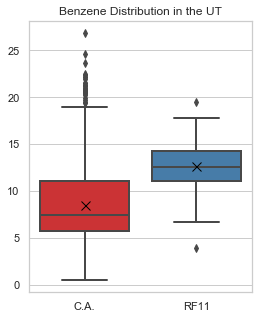

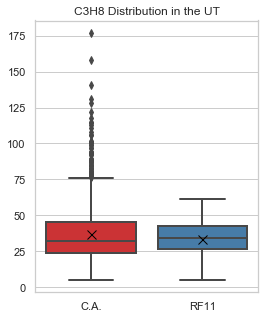

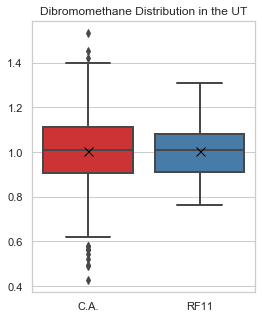

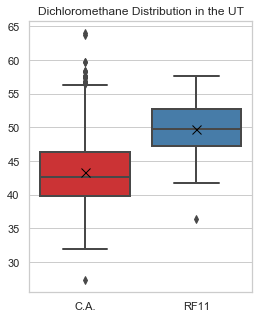

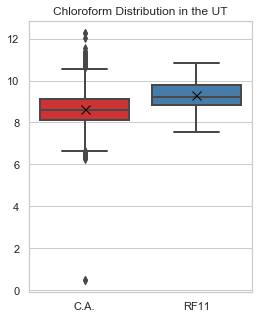

In [367]:
# plot 
where = 'UT'

make_bplot(UT_Benzene, 'Benzene', where)
make_bplot(UT_C3H8, 'C3H8', where)
make_bplot(UT_Dibromomethane, 'Dibromomethane', where)
make_bplot(UT_Dichloromethane, 'Dichloromethane', where)
make_bplot(UT_Chloroform, 'Chloroform', where)

In [362]:
########## plot distributions - BL

In [363]:
# isolate data in UT for RF11 alone, and camp avg. 
gt_bl_campavg = toga_df.loc[(toga_df['GGALT'] < 2000)]
gt_bl_campavg = gt_bl_campavg[['Benzene', 'C3H8', 'Dibromomethane', 'Dichloromethane', 'Chloroform', 'Bromoform']]
gt_bl_campavg = gt_bl_campavg.assign(Location = 1)

gt_bl_9day = toga_df[toga_df['Flight'].isin(['RF11', 'RF10', 'RF09', 'RF08'])]
gt_bl_9day = gt_bl_9day[gt_bl_9day['GGALT'] < 2000]

gt_bl_rf11 = toga_df.loc[(toga_df['GGALT'] < 2000) & (toga_df['Flight'] == 'RF11')]
gt_bl_rf11 = gt_bl_rf11[['Benzene', 'C3H8', 'Dibromomethane', 'Dichloromethane', 'Chloroform', 'Bromoform']]
gt_bl_rf11 = gt_bl_rf11.assign(Location = 2)

In [368]:
BL_Benzene = pd.DataFrame()
BL_Benzene['C.A.'] = gt_bl_campavg['Benzene']
BL_Benzene['9 Day'] = gt_bl_9day['Benzene']
BL_Benzene['RF11'] = gt_bl_rf11['Benzene']

BL_C3H8 = pd.DataFrame()
BL_C3H8['C.A.'] = gt_bl_campavg['C3H8']
BL_C3H8['9 Day'] = gt_bl_9day['C3H8']
BL_C3H8['RF11'] = gt_bl_rf11['C3H8']

BL_Dibromomethane = pd.DataFrame()
BL_Dibromomethane['C.A.'] = gt_bl_campavg['Dibromomethane']
BL_Dibromomethane['9 Day'] = gt_bl_9day['Dibromomethane']
BL_Dibromomethane['RF11'] = gt_bl_rf11['Dibromomethane']

BL_Dichloromethane = pd.DataFrame()
BL_Dichloromethane['C.A.'] = gt_bl_campavg['Dichloromethane']
BL_Dichloromethane['9 Day'] = gt_bl_9day['Dichloromethane']
BL_Dichloromethane['RF11'] = gt_bl_rf11['Dichloromethane']

BL_Chloroform = pd.DataFrame()
BL_Chloroform['C.A.'] = gt_bl_campavg['Chloroform']
BL_Chloroform['9 Day'] = gt_bl_9day['Chloroform']
BL_Chloroform['RF11'] = gt_bl_rf11['Chloroform']


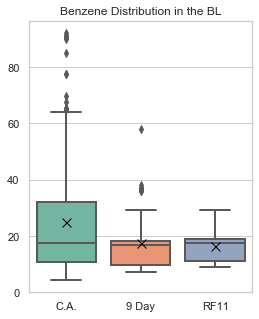

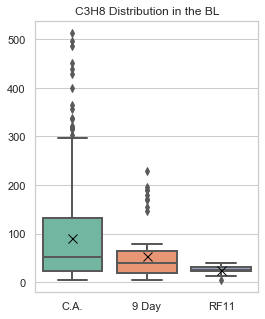

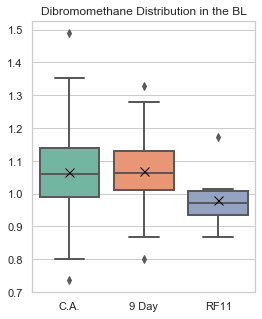

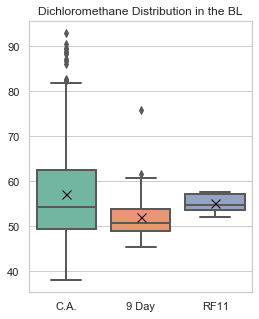

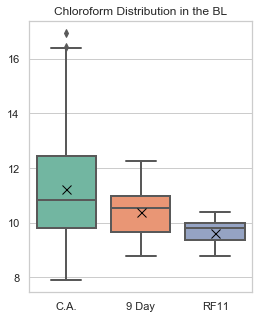

In [369]:
# plot 
where = 'BL'

make_bplot(BL_Benzene, 'Benzene', where)
make_bplot(BL_C3H8, 'C3H8', where)
make_bplot(BL_Dibromomethane, 'Dibromomethane', where)
make_bplot(BL_Dichloromethane, 'Dichloromethane', where)
make_bplot(BL_Chloroform, 'Chloroform', where)

In [ ]:
########## plot location of sample 

In [408]:
# isolate data in UT for RF11 alone, and camp avg. 

### BL 
mybl_campavg = toga_df.loc[(toga_df['GGALT'] < 2000)]
mybl_campavg = mybl_campavg[['GGLAT', 'GGLON', 'Benzene', 'C3H8', 'Dibromomethane', 'Dichloromethane', 'Chloroform', 'Bromoform']]

mybl_9day = toga_df[toga_df['Flight'].isin(['RF11', 'RF10', 'RF09', 'RF08'])]
mybl_9day = mybl_9day[mybl_9day['GGALT'] < 2000]
mybl_9day = mybl_9day[['GGLAT', 'GGLON', 'Benzene', 'C3H8', 'Dibromomethane', 'Dichloromethane', 'Chloroform', 'Bromoform']]

mybl_rf11 = toga_df.loc[(toga_df['GGALT'] < 2000) & (toga_df['Flight'] == 'RF11')]
mybl_rf11 = mybl_rf11[['GGLAT', 'GGLON', 'Benzene', 'C3H8', 'Dibromomethane', 'Dichloromethane', 'Chloroform', 'Bromoform']]

### UT 
myut_rf11 = toga_df.loc[(toga_df['GGALT'] > 12000) & (toga_df['GGALT'] < 14000)
                                                          & (toga_df['Flight'] == 'RF11')]
myut_rf11 = myut_rf11[['GGLAT', 'GGLON', 'Benzene', 'C3H8', 'Dibromomethane', 'Dichloromethane', 'Chloroform', 'Bromoform']]

myut_campavg = toga_df.loc[(toga_df['GGALT'] > 12000) & (toga_df['GGALT'] < 14000)]
myut_campavg = myut_campavg[['GGLAT', 'GGLON', 'Benzene', 'C3H8', 'Dibromomethane', 'Dichloromethane', 'Chloroform', 'Bromoform']]


Text(0, 0.5, 'Latitude')

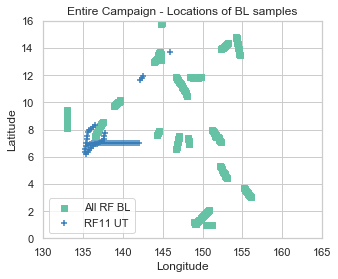

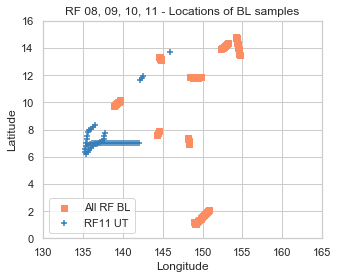

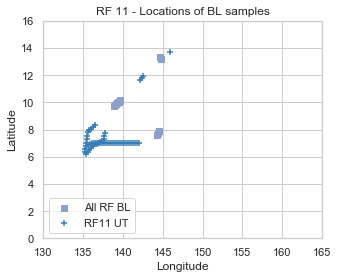

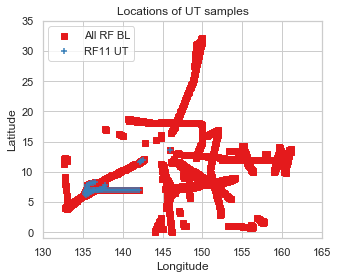

In [416]:
# PLOT BL SAMPLES 
# BL uses Set2 
a = sns.color_palette("Set2")[0]
b = sns.color_palette("Set2")[1]
c = sns.color_palette("Set2")[2]
d = sns.color_palette("Set1")[1]
e = sns.color_palette("Set1")[0]

# camp avg bl 
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(mybl_campavg['GGLON'], mybl_campavg['GGLAT'], marker = 's',
              color = a, label = 'All RF BL') 
ax.scatter(myut_rf11['GGLON'], myut_rf11['GGLAT'], marker = '+',
              color = d, label = 'RF11 UT') 
ax.legend(loc = 'lower left')
ax.set_xlim([130, 165])
ax.set_ylim([0, 16])
ax.set_title('Entire Campaign - Locations of BL samples')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# 9 day bl 
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(mybl_9day['GGLON'], mybl_9day['GGLAT'], marker = 's',
              color = b, label = 'All RF BL') 
ax.scatter(myut_rf11['GGLON'], myut_rf11['GGLAT'], marker = '+',
              color = d, label = 'RF11 UT') 
ax.legend(loc = 'lower left')
ax.set_xlim([130, 165])
ax.set_ylim([0, 16])
ax.set_title('RF 08, 09, 10, 11 - Locations of BL samples')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# RF11 bl 
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(mybl_rf11['GGLON'], mybl_rf11['GGLAT'], marker = 's',
              color = c, label = 'All RF BL') 
ax.scatter(myut_rf11['GGLON'], myut_rf11['GGLAT'], marker = '+',
              color = d, label = 'RF11 UT') 
ax.legend(loc = 'lower left')
ax.set_xlim([130, 165])
ax.set_ylim([0, 16])
ax.set_title('RF 11 - Locations of BL samples')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# UT samples 
fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(myut_campavg['GGLON'], myut_campavg['GGLAT'], marker = 's',
              color = e, label = 'All RF BL') 
ax.scatter(myut_rf11['GGLON'], myut_rf11['GGLAT'], marker = '+',
              color = d, label = 'RF11 UT') 
ax.legend(loc = 'upper left')
ax.set_xlim([130, 165])
ax.set_ylim([-1, 35])
ax.set_title('Locations of UT samples')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

In [ ]:
# UT uses Set1